# Проект для металлургического комбината

## Краткая информация и цель проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Перед нами стоит задача построить модель, которая будет её предсказывать. Нужно разобраться в деталях технологического процесса, чтобы суметь правильно сгенерировать новые входные признаки. После нужно сделать сводную таблицу со всеми важными характеристиками, построить несколько регрессионных моделей и протестировать их. Выбрать лучшую, исходя из оценки среднего абсолютного отклонения. Далее провести анализ признаков и дать рекомендации заказчику.

### План:

1. Загрузить все необходимые библиотеки, определить функции и константы.
2. Загрузить все необходимые датасеты, привести их в порядок и проанализировать их.
3. Сгенерировать новые входные признаки, выбрать из уже существующих нужные, свести их в один датафрейм.
4. Проанализировать новую таблицу, проверить на мультиколлинеарность входные признаки.
5. Построить и протестировать разные регрессионные модели, выбрать из них лучшую по метрике MAE.
6. Провести SHAP-анализ.
7. Написать вывод.

## Загрузка библиотек, определение функций и констант

In [1]:
!pip install phik
!pip install shap
!pip install -U scikit-learn

     |████████████████████████████████| 686 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 539 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 13.4 MB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 64.4 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import shap
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error as MAE

In [3]:
# ячейка для функций
def graf(df, i):
    plt.rcParams['figure.figsize'] = [15, 4]
    sns.set(style='whitegrid')
    plt.subplot(1, 2, 1)
    sns.histplot(data = df, x = df[i], kde=True, bins=10)
    plt.subplot(1, 2, 2)
    sns.boxplot(data = df, x = df[i], palette='pastel')
    plt.show()
    
def names(df):
    names = df.columns.str.lower()
    new_names = [i.replace(' ', '_') for i in names]
    df.columns = new_names
    return df.head()

In [4]:
TEST_SIZE = 0.25
RANDOM_STATE = 30924

## data_arc_new.csv

Это файл с данными об электродах, загрузим его.

In [5]:
data_arc = pd.read_csv('/datasets/data_arc_new.csv', parse_dates=[1, 2])
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [6]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [7]:
names(data_arc)

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


Проверим, что все строки записаны верно (начало нагрева раньше конца нагрева).

In [8]:
data_arc['дельта_время'] = data_arc['конец_нагрева_дугой'] - data_arc['начало_нагрева_дугой']

In [9]:
data_arc['дельта_время'].min()

Timedelta('0 days 00:00:11')

Все строки записаны верно.

In [10]:
data_arc.describe()

,key,активная_мощность,реактивная_мощность,дельта_время
count,14876.000000,14876.000000,14876.000000,14876
mean,1615.220422,0.662752,0.438986,0 days 00:02:51.670946490
std,934.571502,0.258885,5.873485,0 days 00:01:38.186802680
min,1.000000,0.223120,-715.479924,0 days 00:00:11
25%,806.000000,0.467115,0.337175,0 days 00:01:47
50%,1617.000000,0.599587,0.441639,0 days 00:02:27
75%,2429.000000,0.830070,0.608201,0 days 00:03:34
max,3241.000000,1.463773,1.270284,0 days 00:15:07


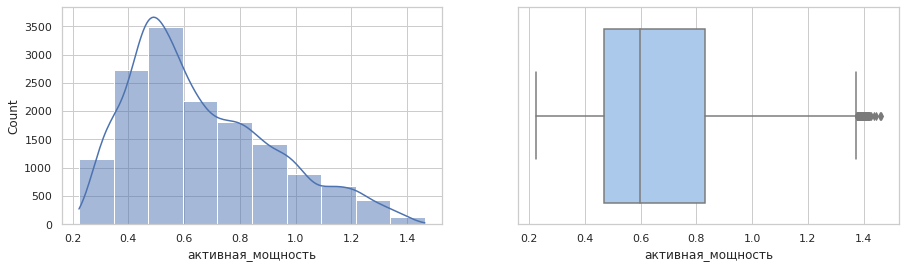

In [11]:
graf(data_arc, 'активная_мощность')

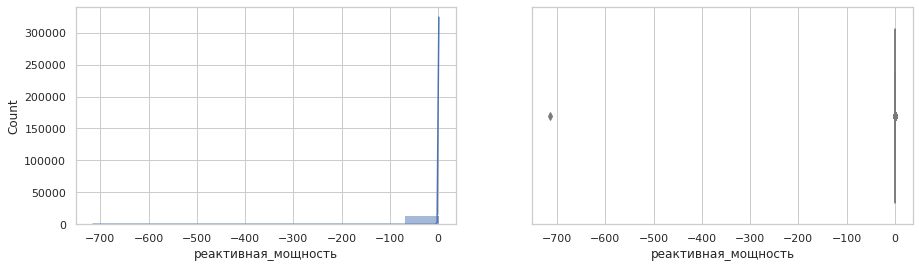

In [12]:
graf(data_arc, 'реактивная_мощность')

Есть выброс, удалим его.

In [13]:
data_arc = data_arc[data_arc['реактивная_мощность'] > -700]
data_arc['реактивная_мощность'].min()

0.153777

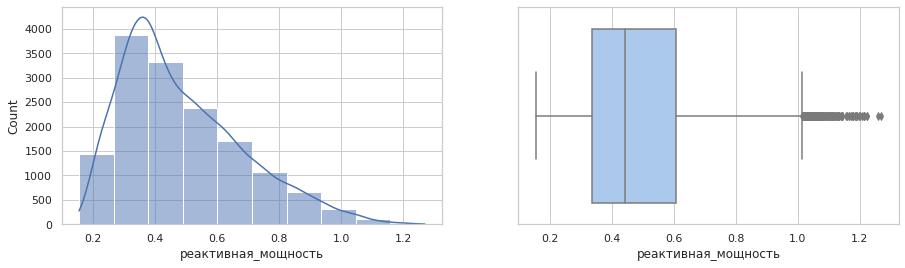

In [14]:
graf(data_arc, 'реактивная_мощность')

У электрического тока помимо _реактивной_ $P$ и _активной_ $Q$ мощностей есть еще и __полная__ мощность &mdash; $S$.

$ S = \sqrt{P^2 + Q^2}$

Добавим новый параметр в датафрейм.

In [15]:
data_arc['полная_мощность'] = np.sqrt(data_arc['активная_мощность']**2 + data_arc['реактивная_мощность']**2)

In [16]:
data_arc.head()

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность,дельта_время,полная_мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0 days 00:03:48,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0 days 00:03:05,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0 days 00:02:52,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0 days 00:06:05,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,0 days 00:02:28,1.079934


In [17]:
data_arc['время_работы'] = data_arc['дельта_время'].dt.total_seconds()
# ранее выяснили, что максимум в этом столбце не превышает 15 минут

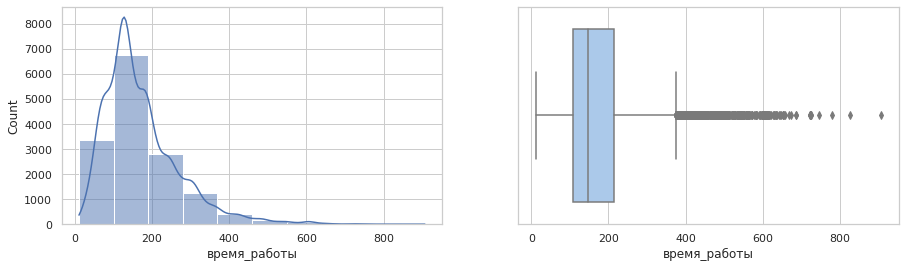

In [18]:
graf(data_arc, 'время_работы')

In [19]:
data_arc.head(20)

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность,дельта_время,полная_мощность,время_работы
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0 days 00:03:48,0.371123,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0 days 00:03:05,0.902319,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0 days 00:02:52,0.722536,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0 days 00:06:05,0.642824,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,0 days 00:02:28,1.079934,148.0
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,0 days 00:02:17,0.440239,137.0
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527,0 days 00:05:38,0.332731,338.0
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962,0 days 00:02:06,0.860064,126.0
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517,0 days 00:03:30,0.955315,210.0
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856,0 days 00:04:40,1.373863,280.0


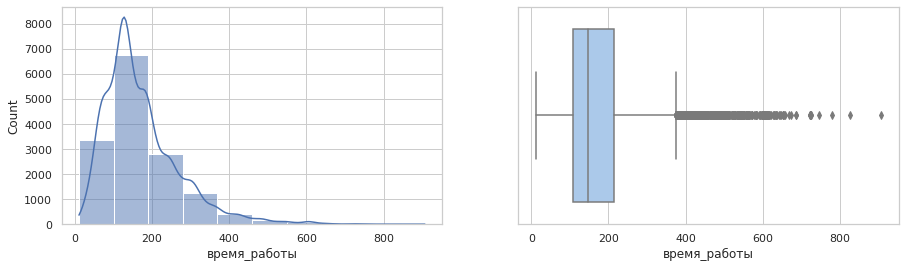

In [20]:
graf(data_arc, 'время_работы')

Создадим новый датасет с усредненными данными полной мощности,полной и средней времени работы по ключу.

In [21]:
data_arc_new = data_arc.groupby('key')['полная_мощность'].sum().reset_index()
data_arc_new.columns = ['key', 'полная_мощность_сум']
data_arc_new.head()

,key,полная_мощность_сум
0,1,3.718736
1,2,2.588349
2,3,5.019223
3,4,3.400038
4,5,2.816980


In [22]:
_ = data_arc.groupby('key')['время_работы'].mean().reset_index()
_.columns = ['key', 'время_работы_ср']
data_arc_new = pd.merge(data_arc_new, _, on='key')

In [23]:
_ = data_arc.groupby('key')['время_работы'].sum().reset_index()
_.columns = ['key', 'время_работы_общ']
data_arc_new = pd.merge(data_arc_new, _, on='key')

In [24]:
_ = data_arc.groupby('key')['время_работы'].count().reset_index()
_.columns = ['key', 'количество_периодов_нагрева']
data_arc_new = pd.merge(data_arc_new, _, on='key')
data_arc_new.head()

,key,полная_мощность_сум,время_работы_ср,время_работы_общ,количество_периодов_нагрева
0,1,3.718736,219.60,1098.0,5
1,2,2.588349,202.75,811.0,4
2,3,5.019223,131.00,655.0,5
3,4,3.400038,185.25,741.0,4
4,5,2.816980,217.25,869.0,4


In [25]:
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   key                          3214 non-null   int64  
 1   полная_мощность_сум          3214 non-null   float64
 2   время_работы_ср              3214 non-null   float64
 3   время_работы_общ             3214 non-null   float64
 4   количество_периодов_нагрева  3214 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 150.7 KB


## data_bulk_new.csv

Это файл с данными о подаче сыпучих материалов (объём).

In [26]:
data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [27]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [28]:
names(data_bulk)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [29]:
data_bulk.fillna(value=0, inplace=True)
data_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


## data_bulk_time_new.csv

Это файл с данными о подаче сыпучих материалов (время).

In [30]:
data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv', parse_dates=list(range(1, 16)))
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


In [31]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


In [32]:
names(data_bulk_time)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


Я думаю, что время подачи не влияет на температуру. Если бы таргетом была не последний замер температуры, а каждый, то тогда следовало бы учесть данные этой таблицы, чтобы составить таблицу со сводными характеристиками, которые были актуальны на момент замера температуры.

## data_gas_new.csv

Это файл с данными о продувке сплава газом.

In [33]:
data_gas = pd.read_csv('/datasets/data_gas_new.csv')
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [34]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [35]:
names(data_gas)

,key,газ_1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


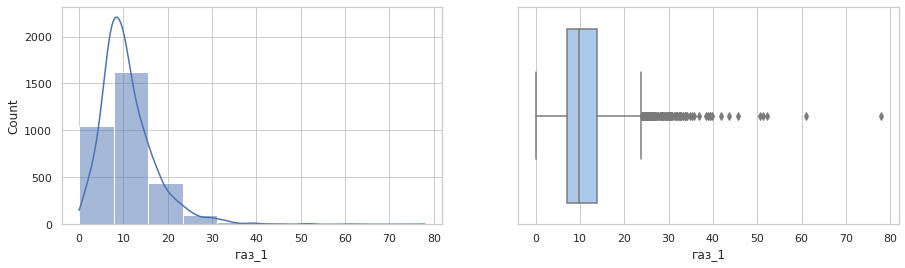

In [36]:
graf(data_gas, 'газ_1')

## data_temp_new.csv

Это файл с результатами измерения температуры.

In [37]:
data_temp = pd.read_csv('/datasets/data_temp_new.csv', parse_dates=[1])
data_temp.head(20)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [38]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [39]:
names(data_temp)

,key,время_замера,температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


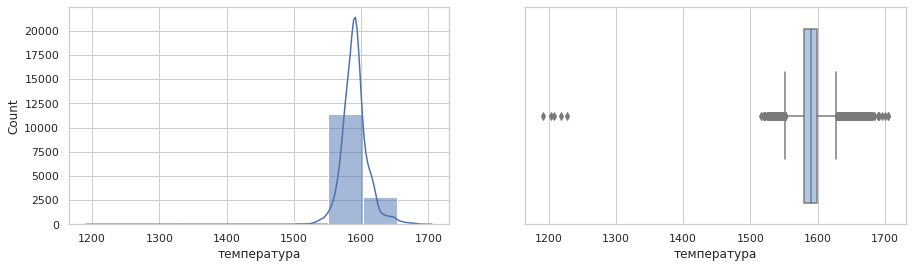

In [40]:
graf(data_temp, 'температура')

In [41]:
data_temp = data_temp[data_temp['температура'] > 1400] # температура плавления стали равна 1400 градусов

Проверим, что все строки идут последовательно.

In [42]:
data_temp['разница_значений'] = data_temp['время_замера'].diff().dt.total_seconds()
data_temp[data_temp['разница_значений'] < 0]

,key,время_замера,температура,разница_значений
1105,195,2019-05-11 00:01:36,1583.0,-404.0


In [43]:
data_temp.iloc[list(range(1100, 1111))]

,key,время_замера,температура,разница_значений
1100,193,2019-05-10 22:40:56,1595.0,425.0
1101,194,2019-05-10 23:17:57,1644.0,2221.0
1102,194,2019-05-10 23:47:07,1609.0,1750.0
1103,194,2019-05-10 23:51:31,1599.0,264.0
1104,194,2019-05-11 00:08:20,1603.0,1009.0
1105,195,2019-05-11 00:01:36,1583.0,-404.0
1106,196,2019-05-11 01:11:43,1624.0,4207.0
1107,196,2019-05-11 01:45:19,1607.0,2016.0
1108,196,2019-05-11 01:49:36,1603.0,257.0
1109,196,2019-05-11 02:08:05,1599.0,1109.0


Ошибки в данных нет.

В этом датасете находится target &mdash; последний замер температуры ковша. Также важна температура, с которой начинался нагрев. Создам новый датасет, где оставлю только первый и последний замер температуры.

Также нужно удалить те ковши, у которых только один замер температуры &mdash; таргет не определить.

In [44]:
_ = data_temp['key'].value_counts()
_ = _[_ == 1]
to_drop = list(_.index)
data_temp = data_temp[~data_temp['key'].isin(to_drop)]

In [45]:
data_temp['key'].value_counts().head()

2108    17
1513    16
1689    16
322     14
46      14
Name: key, dtype: int64

In [46]:
data_temp_new = data_temp.drop_duplicates(subset=['key'], keep='last')
data_temp_new.head()

,key,время_замера,температура,разница_значений
5,1,2019-05-03 11:30:38,1613.0,279.0
10,2,2019-05-03 11:55:09,1602.0,331.0
16,3,2019-05-03 12:35:57,1599.0,293.0
21,4,2019-05-03 12:59:47,1625.0,405.0
26,5,2019-05-03 13:36:39,1602.0,245.0


Для исследования столбцы со временем замера и разницей значений не нужны. Оставлю только нужные.

In [47]:
data_temp_new = data_temp_new[['key', 'температура']]
data_temp_new.columns = ['key', 'температура_1']

In [48]:
_ = data_temp.drop_duplicates(subset=['key'], keep='first')
_ = _[['key', 'температура']]
_.columns = ['key', 'температура_0']

In [49]:
data_temp_new = pd.merge(data_temp_new, _, on='key')

In [50]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            2475 non-null   int64  
 1   температура_1  2475 non-null   float64
 2   температура_0  2475 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 77.3 KB


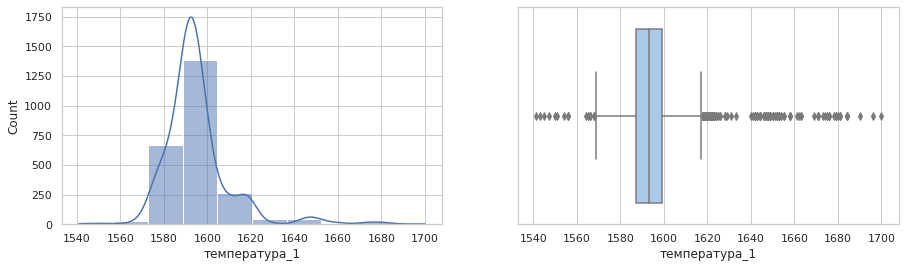

In [51]:
graf(data_temp_new, 'температура_1')

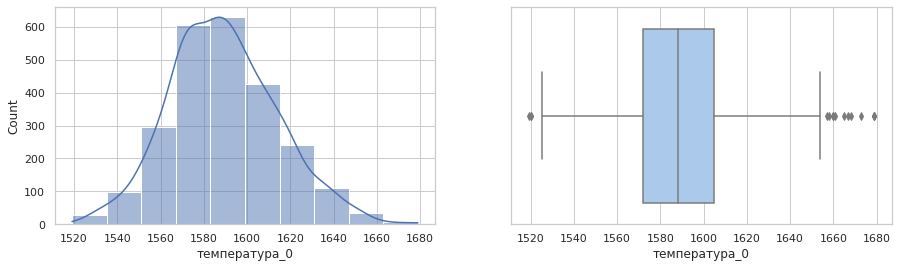

In [52]:
graf(data_temp_new, 'температура_0')

## data_wire_new.csv

Это файл с данными о проволочных материалах (объём).

In [53]:
data_wire = pd.read_csv('/datasets/data_wire_new.csv')
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [55]:
names(data_wire)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
data_wire.fillna(value=0, inplace=True)
data_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## data_wire_time_new.csv

Это файл с данными о проволочных материалах (время).

In [57]:
data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv', parse_dates=list(range(1, 10)))
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [58]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


In [59]:
names(data_wire_time)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


Этот датафрейм я тоже считаю не нужным для решения нашей задачи.

## Создание сводной таблицы

Буду присоединять таблицы начиная с датафрейма с данными о температуре, так как он является таргетом.

In [60]:
df = pd.merge(data_temp_new, data_arc_new, on='key')
l = [data_bulk, data_gas, data_wire]
for i in l:
    df = pd.merge(df, i, on='key')
df.head()

,key,температура_1,температура_0,полная_мощность_сум,время_работы_ср,время_работы_общ,количество_периодов_нагрева,bulk_1,bulk_2,bulk_3,...,газ_1,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,1613.0,1571.0,3.718736,219.60,1098.0,5,0.0,0.0,0.0,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1602.0,1581.0,2.588349,202.75,811.0,4,0.0,0.0,0.0,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1599.0,1596.0,5.019223,131.00,655.0,5,0.0,0.0,0.0,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1625.0,1601.0,3.400038,185.25,741.0,4,0.0,0.0,0.0,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1602.0,1576.0,2.816980,217.25,869.0,4,0.0,0.0,0.0,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   key                          2329 non-null   int64  
 1   температура_1                2329 non-null   float64
 2   температура_0                2329 non-null   float64
 3   полная_мощность_сум          2329 non-null   float64
 4   время_работы_ср              2329 non-null   float64
 5   время_работы_общ             2329 non-null   float64
 6   количество_периодов_нагрева  2329 non-null   int64  
 7   bulk_1                       2329 non-null   float64
 8   bulk_2                       2329 non-null   float64
 9   bulk_3                       2329 non-null   float64
 10  bulk_4                       2329 non-null   float64
 11  bulk_5                       2329 non-null   float64
 12  bulk_6                       2329 non-null   float64
 13  bulk_7            

## Коррелляционный анализ

In [62]:
num_columns = list(df.columns)
num_columns.remove('количество_периодов_нагрева')

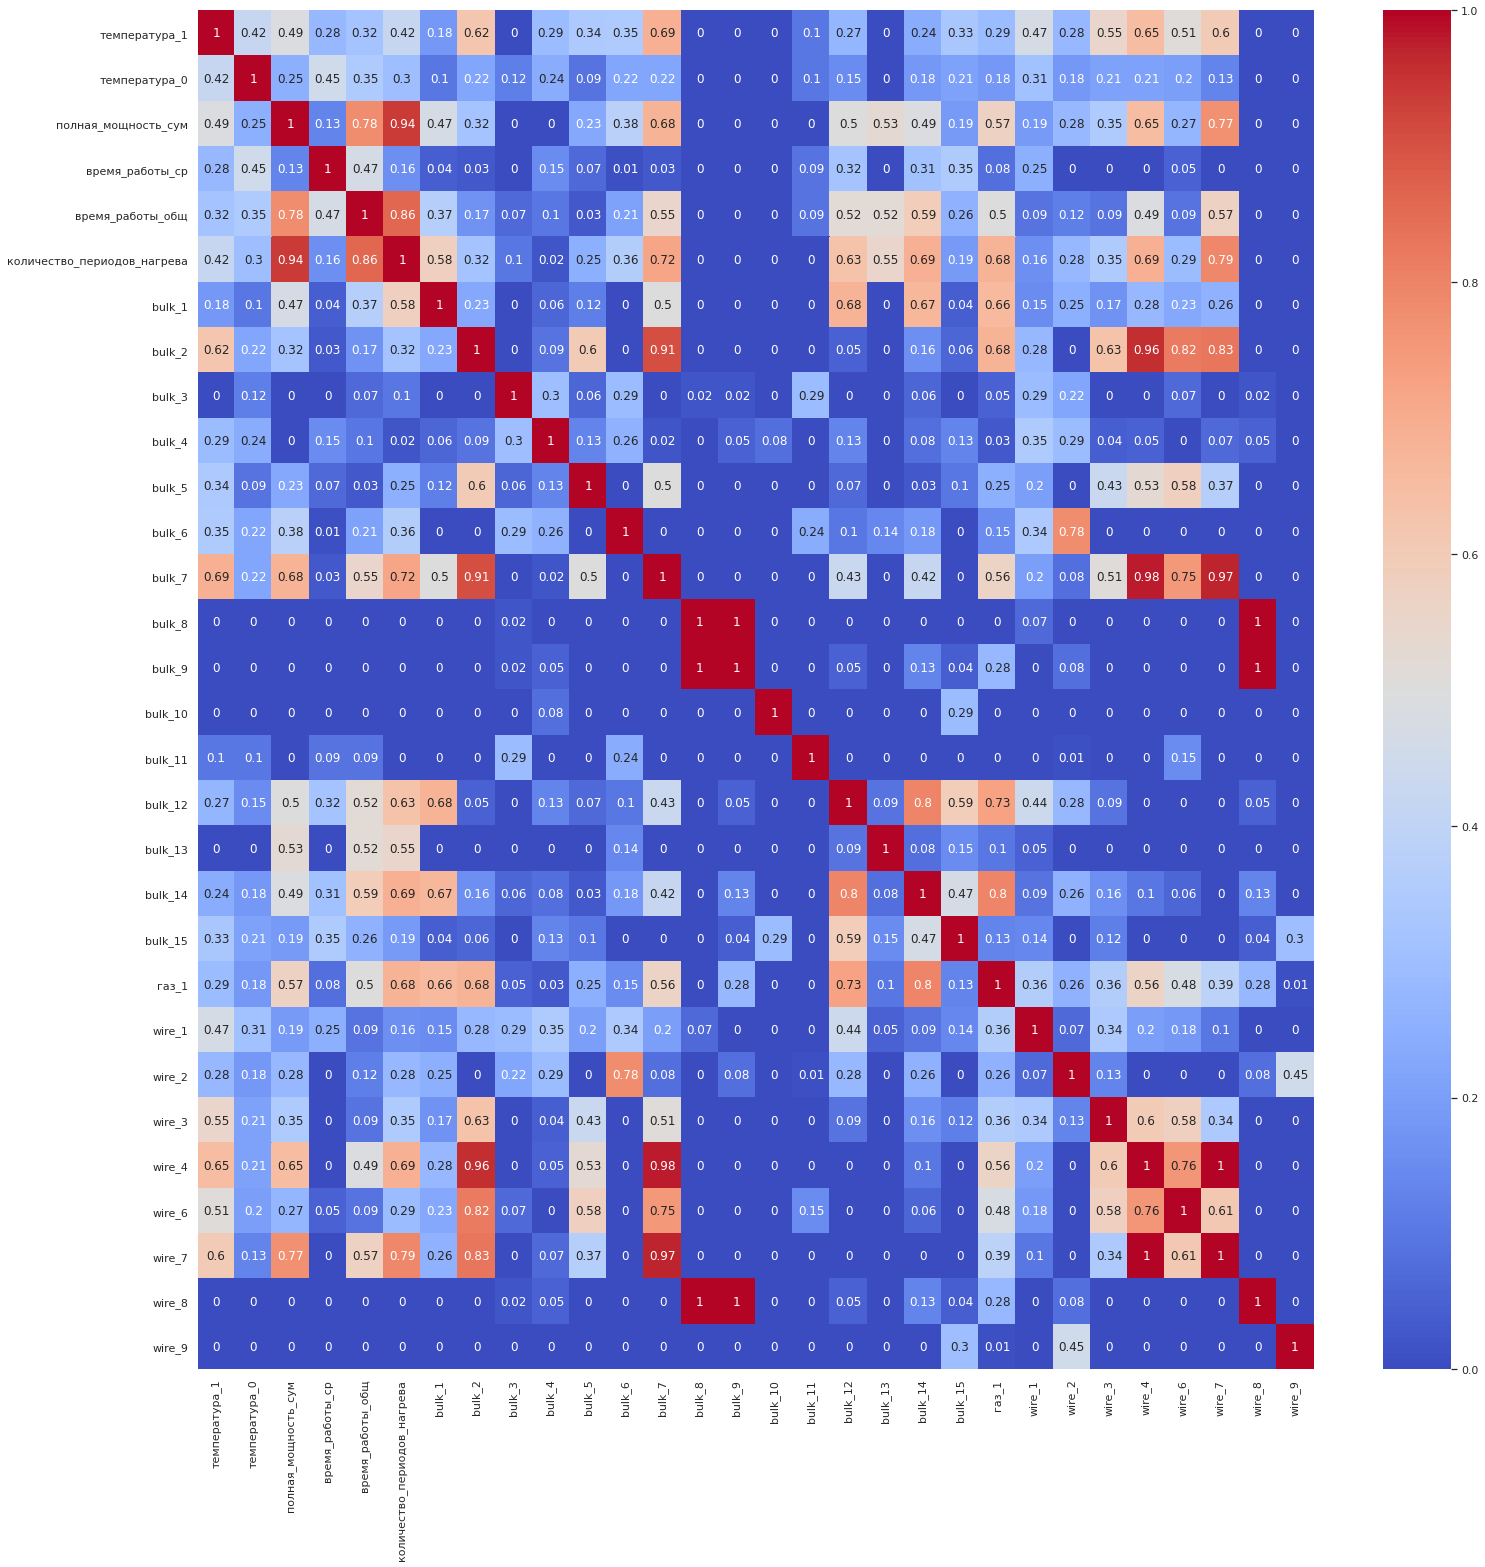

In [63]:
warnings.filterwarnings('ignore')

corr_mat = df.drop('key', axis=1).phik_matrix(interval_cols=num_columns)
corr_mat = corr_mat.applymap(lambda x: round(x, 2))

plt.figure(figsize=(25, 25))
sns.set(font_scale=1)
sns.heatmap(corr_mat, annot=True, cmap='coolwarm')
plt.show()

Удалю столбец 'количество_периодов_нагрева', 'bulk_8', 'bulk_7', 'wire_8', 'wire_4'.

In [64]:
df = df.drop('количество_периодов_нагрева', axis=1)
df = df.drop('bulk_8', axis=1)
df = df.drop('bulk_7', axis=1)
df = df.drop('wire_8', axis=1)
df = df.drop('wire_4', axis=1)

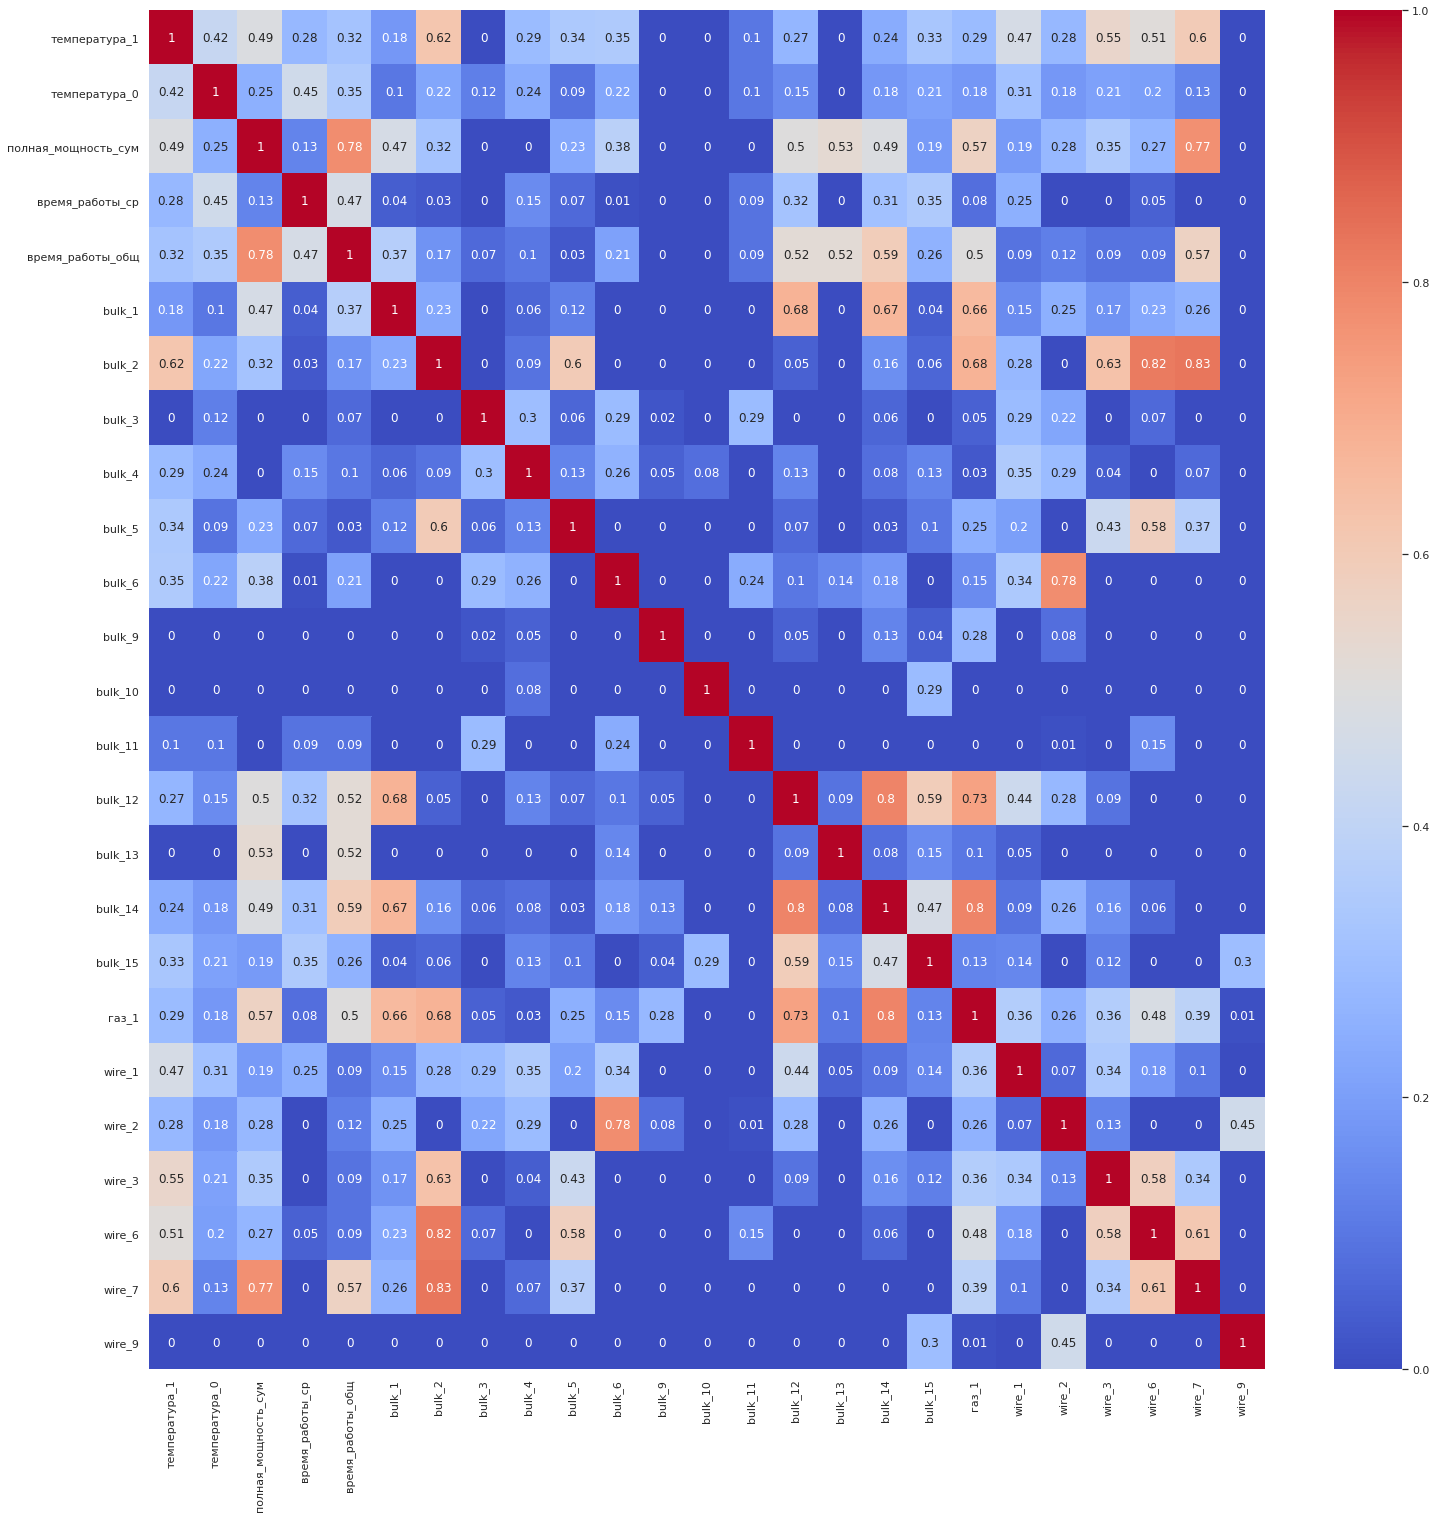

In [65]:
num_columns = list(df.columns)

corr_mat = df.drop('key', axis=1).phik_matrix(interval_cols=num_columns)
corr_mat = corr_mat.applymap(lambda x: round(x, 2))

plt.figure(figsize=(25, 25))
sns.set(font_scale=1)
sns.heatmap(corr_mat, annot=True, cmap='coolwarm')
plt.show()

## Построение пайплайна

In [66]:
num_columns.remove('key')
num_columns.remove('температура_1')

In [67]:
df = df.drop('key', axis=1)
X = df.drop('температура_1', axis=1)
y = df['температура_1']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

In [68]:
data_preprocessor = ColumnTransformer(
    [('num', MinMaxScaler(), num_columns)], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

param_grid = [
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для SVC()
    {
        'models': [SVC()],
        'models__kernel': ['rbf', 'sigmoid', 'linear', 'poly'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # словарь для LGBMRegressor()
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__num_leaves': range(1, 100, 4),
        'models__max_depth': range(1, 20),
        'models__n_estimators': range(1, 100, 4),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', -randomized_search.best_score_)

y_test_pred = randomized_search.predict(X_test)
print(f'Метрика MAE на тестовой выборке: {MAE(y_test, y_test_pred)}')


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['температура_0',
                                                   'полная_мощность_сум',
                                                   'время_работы_ср',
                                                   'время_работы_общ', 'bulk_1',
                                                   'bulk_2', 'bulk_3', 'bulk_4',
                                                   'bulk_5', 'bulk_6', 'bulk_9',
                                                   'bulk_10', 'bulk_11',
                                                   'bulk_12', 'bulk_13',
                                                   'bulk_14', 'bulk_15',
                                                   'газ_1', 'wire_1', 'wire_2',
                                                

## Анализ признаков

  0%|          | 0/583 [00:00<?, ?it/s]

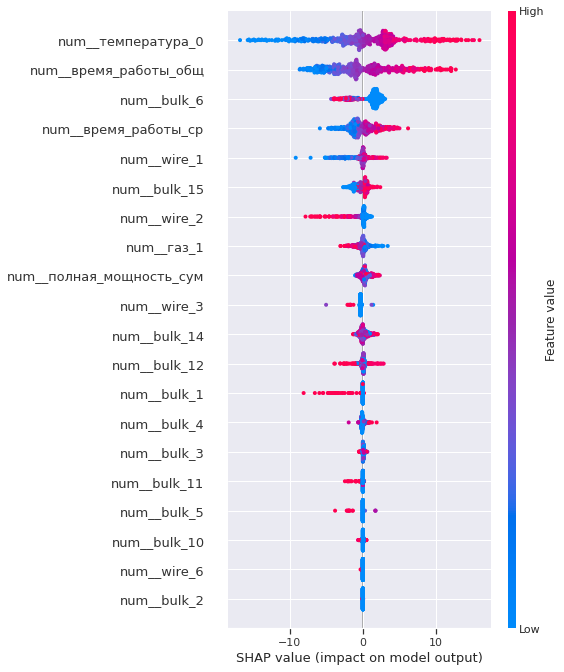

In [69]:
model = randomized_search.best_estimator_.named_steps['models']
pre = randomized_search.best_estimator_.named_steps['preprocessor']

_ = pre.transform(X_test)
names = pre.get_feature_names_out()
data = pd.DataFrame(data=_, columns=names)

X_test_summary = shap.kmeans(data, 10)

ex = shap.KernelExplainer(model.predict, X_test_summary)
shap_values = ex.shap_values(data)
shap.summary_plot(shap_values, data)

Из графика beeswarm можно сказать, что наибольший вклад в конечную температуру имеет температура начальная: чем она была ниже, тем ниже будет итоговая. Также стоит сказать про общее время работы: чем чаще и чем дольше происходят нагревы ковша, тем его итоговая температура выше.

Что можно здесь предложить заказчику? Нужно найти оптимальное количество периодов и времени нагрева, чтоы не делать это слишком часто. Тем более, что частые периоды нагревания-остывания ухудшают состояние внутренней части ковша, что увеличивает расходы на амортизацию. Можно попробовать снизить начальную температуру ковша. Возможно, это приведет к более длительному процессу изготовления изделий, но финальная температура снизится.

## Вывод

В процессе работы над проектом я выполнил план, намеченный в начале. Загрузил все необходимые для работы иинструменты, все датафреймы, проанализировал их. Сгенерировал новые входные признаки и учел уже существующие, свел их в одну таблицу с таргетом. Провел исследовательский и корреляционный анализ, скорректировал таблицу для правильного построения регрессионных моделей. Выделил наилучшую, которая показала метрику МАЕ=6.27 на тестовой выборке. Провел анализ признаков и написал возможные рекомендации заказчику: 1) найти оптимальное количество периодов и времени нагрева, 2) снизить начальную температуру ковша.